# 📊 ANALYSE COMPLÈTE DE LA BASE CLASSICMODELS
## Visualisation et analyse des données commerciales

# 📊 ANALYSE COMPLÈTE DE LA BASE CLASSICMODELS
## Visualisation et analyse des données commerciales

## Objectif de ce notebook

Ce notebook Jupyter a pour objectif d'analyser en profondeur la base de données ClassicModels, un distributeur de maquettes de voitures anciennes. À travers 6 analyses complémentaires, nous allons explorer :

1. **L'évolution temporelle** des ventes
2. **La répartition géographique** des clients et du chiffre d'affaires
3. **Les performances par gamme** de produits
4. **Les top produits** et leur comportement
5. **L'état des stocks** et les risques de rupture
6. **L'analyse de la clientèle** selon le principe de Pareto (80/20)

Chaque analyse sera accompagnée de graphiques interprétés et de commentaires détaillés pour une compréhension approfondie des données.

---

## Prérequis

- Python 3.8 ou supérieur
- Connexion à une base MySQL avec la base ClassicModels installée
- Bibliothèques : pandas, numpy, matplotlib, seaborn, mysql.connector

---

## 1. Import des bibliothèques nécessaires

In [1]:
# Cellule 1 : Import des bibliothèques

import mysql.connector
from mysql.connector import pooling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Bibliothèques importées avec succès")
print(f"📊 Version de pandas : {pd.__version__}")
print(f"📈 Version de matplotlib : {plt.matplotlib.__version__}")


✅ Bibliothèques importées avec succès
📊 Version de pandas : 3.0.0
📈 Version de matplotlib : 3.10.8


In [2]:
# Cellule 2 : Chargement des variables d'environnement

load_dotenv()

# Paramètres de connexion (à modifier si nécessaire)
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'user': os.getenv('DB_USER', 'root'),
    'password': os.getenv('DB_PASSWORD', 'Christevy'),
    'database': os.getenv('DB_NAME', 'projet_sql_py')
}

print("🔧 Configuration chargée :")
print(f"   • Hôte : {DB_CONFIG['host']}")
print(f"   • Utilisateur : {DB_CONFIG['user']}")
print(f"   • Base de données : {DB_CONFIG['database']}")

🔧 Configuration chargée :
   • Hôte : localhost
   • Utilisateur : root
   • Base de données : projet_sql_py


## 3. Classe de connexion à la base de données

Nous créons une classe dédiée pour gérer les connexions à MySQL. Cette classe utilise un pool de connexions 
pour optimiser les performances lors de multiples requêtes.

In [3]:
# Cellule 3 : Classe de connexion MySQL

class MySQLVisualizer:
    """Classe pour la visualisation des données MySQL"""
    
    def __init__(self, config):
        """Initialisation du pool de connexions MySQL"""
        try:
            self.connection_params = config
            
            self.pool = mysql.connector.pooling.MySQLConnectionPool(
                pool_name="mypool",
                pool_size=5,
                pool_reset_session=True,
                **self.connection_params
            )
            print("✅ Connexion à la base de données établie")
        except Exception as e:
            print(f"❌ Erreur de connexion: {e}")
            self.pool = None
        
        self.output_dir = "visualizations"
        os.makedirs(self.output_dir, exist_ok=True)
        
    def get_connection(self):
        """Obtient une connexion du pool"""
        if self.pool:
            try:
                return self.pool.get_connection()
            except:
                return mysql.connector.connect(**self.connection_params)
        else:
            return mysql.connector.connect(**self.connection_params)
    
    def execute_query(self, query, params=None):
        """Exécute une requête SQL et retourne un DataFrame"""
        connection = None
        try:
            connection = self.get_connection()
            df = pd.read_sql(query, connection, params=params)
            return df
        except Exception as e:
            print(f"❌ Erreur lors de l'exécution de la requête: {e}")
            print(f"Requête: {query[:200]}...")
            return pd.DataFrame()
        finally:
            if connection:
                connection.close()
    
    def convert_to_numeric(self, df, columns):
        """Convertit les colonnes en valeurs numériques"""
        for col in columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        return df
    
    def safe_plot(self, fig, filename):
        """Sauvegarde et affiche un graphique de manière sécurisée"""
        try:
            plt.tight_layout()
            plt.savefig(f'{self.output_dir}/{filename}', 
                       dpi=300, bbox_inches='tight')
            print(f"✅ Graphique sauvegardé: {self.output_dir}/{filename}")
            plt.show()
            plt.close()
        except Exception as e:
            print(f"❌ Erreur lors de la sauvegarde du graphique: {e}")
            plt.close()

# Initialisation du visualiseur
viz = MySQLVisualizer(DB_CONFIG)

✅ Connexion à la base de données établie


# PARTIE 1 : ANALYSE DE L'ÉVOLUTION TEMPORELLE DES VENTES

## Objectif de l'analyse

L'analyse temporelle permet de comprendre la dynamique des ventes dans le temps. Nous allons examiner trois indicateurs clés :

1. **Le chiffre d'affaires mensuel** : pour identifier les tendances et les pics d'activité
2. **Le nombre de commandes** : pour mesurer le volume d'activité
3. **Le panier moyen** : pour évaluer la valeur moyenne des commandes

Ces indicateurs nous aideront à détecter la saisonnalité, les tendances de croissance et les éventuelles anomalies.

## Requête SQL utilisée

```sql
SELECT 
    DATE_FORMAT(o.orderDate, '%Y-%m') AS mois,
    SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
    COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
    AVG(od.quantityOrdered * od.priceEach) AS panier_moyen
FROM orders o
JOIN orderdetails od ON o.orderNumber = od.orderNumber
WHERE o.status NOT IN ('Cancelled', 'On Hold')
GROUP BY DATE_FORMAT(o.orderDate, '%Y-%m')
ORDER BY mois

In [4]:

# Cellule 4 : Extraction des données temporelles

def evolution_ventes_temps(viz):
    """Graphiques d'évolution temporelle des ventes"""
    print("📈 Génération des graphiques d'évolution temporelle...")
    
    query_mois = """
    SELECT 
        DATE_FORMAT(o.orderDate, '%Y-%m') AS mois,
        SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
        COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
        AVG(od.quantityOrdered * od.priceEach) AS panier_moyen
    FROM orders o
    JOIN orderdetails od ON o.orderNumber = od.orderNumber
    WHERE o.status NOT IN ('Cancelled', 'On Hold')
    GROUP BY DATE_FORMAT(o.orderDate, '%Y-%m')
    ORDER BY mois
    """
    
    df_mois = viz.execute_query(query_mois)
    
    if df_mois.empty:
        print("❌ Aucune donnée temporelle trouvée")
        return None
    
    # Conversion numérique
    df_mois = viz.convert_to_numeric(df_mois, 
        ['chiffre_affaires', 'nombre_commandes', 'panier_moyen'])
    df_mois = df_mois.fillna(0)
    
    return df_mois

# Exécution
df_mois = evolution_ventes_temps(viz)

if df_mois is not None:
    print(f"\n✅ {len(df_mois)} mois d'activité extraits")
    print("\n📋 Aperçu des données :")
    display(df_mois.head())

📈 Génération des graphiques d'évolution temporelle...

✅ 29 mois d'activité extraits

📋 Aperçu des données :


,mois,chiffre_affaires,nombre_commandes,panier_moyen
0,2003-01,116692.77,5,2992.122308
1,2003-02,128403.64,3,3131.796098
2,2003-03,160517.14,6,3210.342800
3,2003-04,185848.59,7,3204.286034
4,2003-05,179435.55,6,3093.716379


### Graphique 1.1 : Évolution du chiffre d'affaires mensuel

Ce graphique en courbes montre l'évolution du chiffre d'affaires mois par mois. 
La ligne bleue avec des marqueurs permet de visualiser :
- La tendance générale (haussière, baissière ou stable)
- Les pics d'activité (mois avec CA exceptionnel)
- Les creux (mois plus faibles)
- La saisonnalité éventuelle

Le remplissage sous la courbe (zone bleue) aide à visualiser l'amplitude des variations.

✅ Graphique sauvegardé: visualizations/evolution_ca_mensuel.png


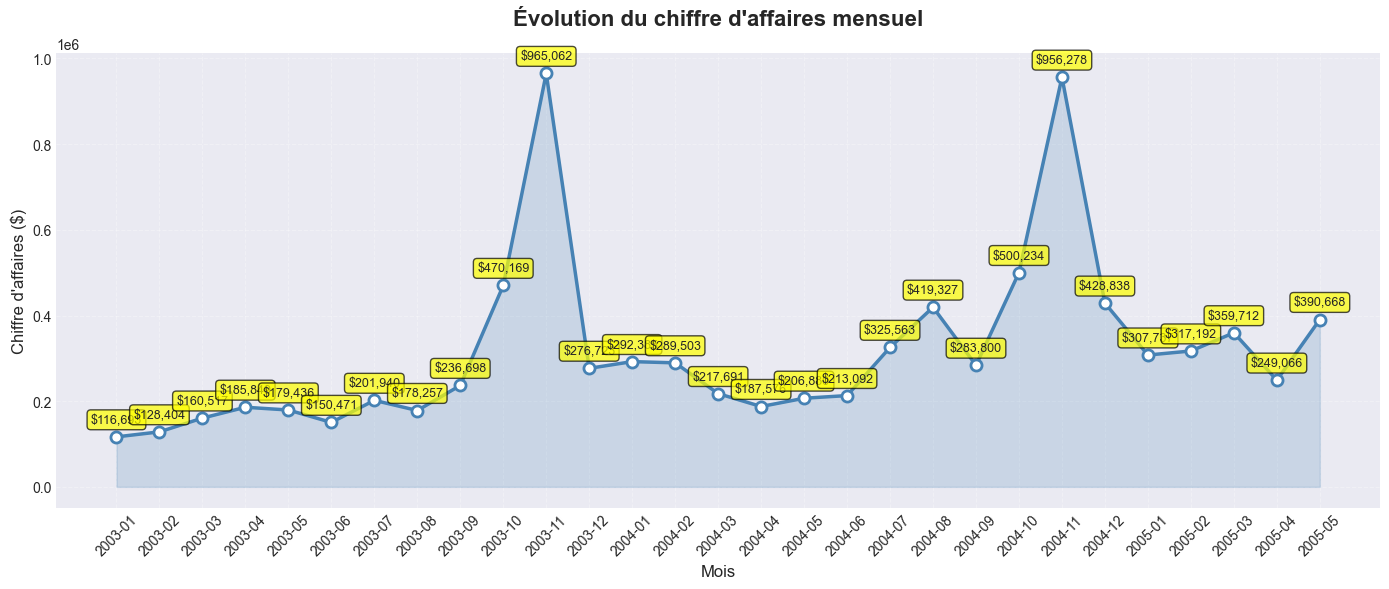


📈 INTERPRÉTATION :
• Période analysée : du 2003-01 au 2005-05
• CA total : $9,195,760.82
• CA moyen mensuel : $317,095.20
• Mois avec le plus fort CA : 2003-11 ($965,061.55)
📈 Tendance : Forte croissance (+234.8% sur la période)


In [5]:
# Cellule 5 : Graphique 1 - Évolution du CA mensuel

if df_mois is not None and len(df_mois) > 0:
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    x = range(len(df_mois))
    
    # Tracé de la courbe
    ax1.plot(x, df_mois['chiffre_affaires'], 
           marker='o', linewidth=2.5, color='steelblue', 
           markersize=8, markerfacecolor='white', 
           markeredgewidth=2, markeredgecolor='steelblue')
    
    # Remplissage sous la courbe
    ax1.fill_between(x, df_mois['chiffre_affaires'], 
                    alpha=0.2, color='steelblue')
    
    # Personnalisation
    ax1.set_title('Évolution du chiffre d\'affaires mensuel', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Mois', fontsize=12)
    ax1.set_ylabel('Chiffre d\'affaires ($)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_mois['mois'], rotation=45, fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Ajout des valeurs sur les points
    for i, (mois, ca) in enumerate(zip(df_mois['mois'], df_mois['chiffre_affaires'])):
        ax1.annotate(f'${ca:,.0f}', (i, ca), textcoords="offset points", 
                   xytext=(0, 10), ha='center', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    viz.safe_plot(fig1, 'evolution_ca_mensuel.png')
    
    # Interprétation
    print("\n📈 INTERPRÉTATION :")
    print(f"• Période analysée : du {df_mois['mois'].iloc[0]} au {df_mois['mois'].iloc[-1]}")
    print(f"• CA total : ${df_mois['chiffre_affaires'].sum():,.2f}")
    print(f"• CA moyen mensuel : ${df_mois['chiffre_affaires'].mean():,.2f}")
    print(f"• Mois avec le plus fort CA : {df_mois.loc[df_mois['chiffre_affaires'].idxmax(), 'mois']} (${df_mois['chiffre_affaires'].max():,.2f})")
    
    # Détection de tendance
    if len(df_mois) > 1:
        evolution = ((df_mois['chiffre_affaires'].iloc[-1] - df_mois['chiffre_affaires'].iloc[0]) / df_mois['chiffre_affaires'].iloc[0]) * 100
        if evolution > 10:
            print(f"📈 Tendance : Forte croissance (+{evolution:.1f}% sur la période)")
        elif evolution > 2:
            print(f"📈 Tendance : Croissance modérée (+{evolution:.1f}%)")
        elif evolution > -2:
            print("➡️ Tendance : Stable")
        elif evolution > -10:
            print(f"📉 Tendance : Légère baisse ({evolution:.1f}%)")
        else:
            print(f"📉 Tendance : Forte baisse ({evolution:.1f}%)")

### Graphique 1.2 : Nombre de commandes mensuelles

Ce diagramme en barres présente le volume d'activité en termes de commandes. 
Il permet de voir si l'évolution du CA est due à une augmentation du nombre de commandes 
ou à une hausse du panier moyen.

Les barres rouges mettent en évidence :
- Les mois les plus actifs (commandes nombreuses)
- Les mois creux (faible activité)
- La régularité ou l'irrégularité de l'activité

✅ Graphique sauvegardé: visualizations/evolution_commandes_mensuelles.png


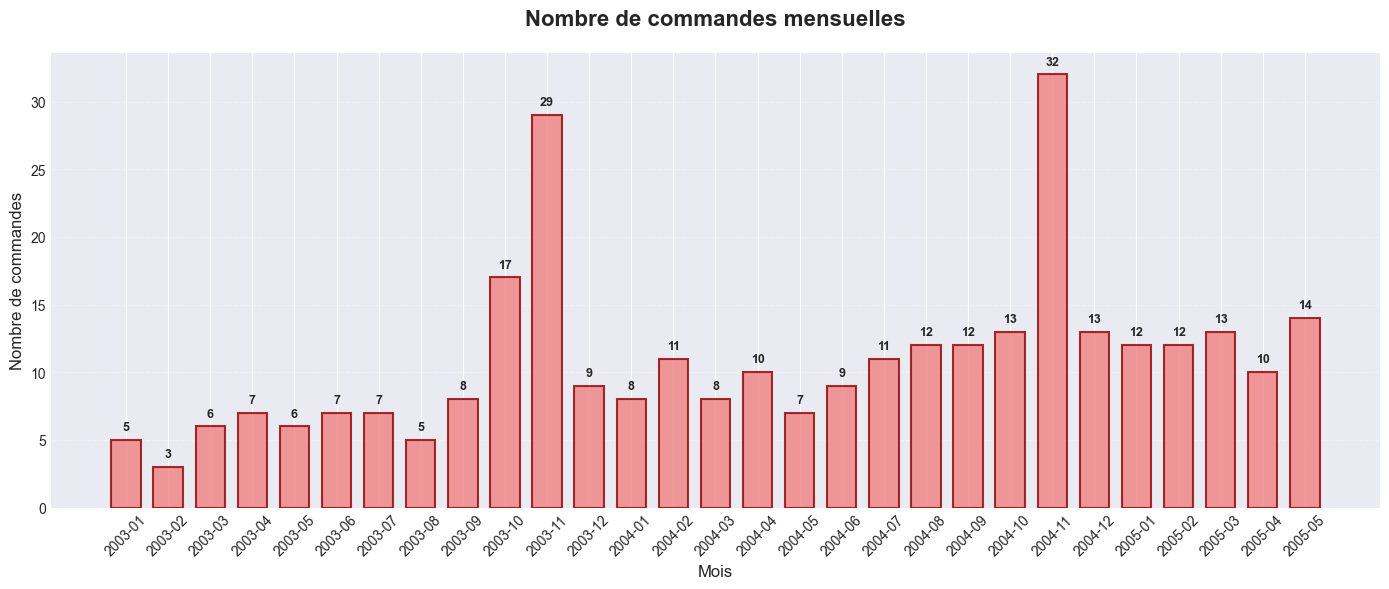


📊 INTERPRÉTATION :
• Total des commandes : 316
• Moyenne mensuelle : 10.9 commandes
• Mois avec le plus de commandes : 2004-11 (32 commandes)
• Mois avec le moins de commandes : 2003-02 (3 commandes)
🔄 Forte corrélation entre nombre de commandes et CA : la croissance est principalement volumique


In [6]:
# Cellule 6 : Graphique 2 - Nombre de commandes mensuelles

if df_mois is not None and len(df_mois) > 0:
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    
    # Création du barplot
    bars = ax2.bar(range(len(df_mois)), df_mois['nombre_commandes'], 
                   color='lightcoral', alpha=0.8, edgecolor='darkred', 
                   linewidth=1.5, width=0.7)
    
    # Personnalisation
    ax2.set_title('Nombre de commandes mensuelles', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Mois', fontsize=12)
    ax2.set_ylabel('Nombre de commandes', fontsize=12)
    ax2.set_xticks(range(len(df_mois)))
    ax2.set_xticklabels(df_mois['mois'], rotation=45, fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, df_mois['nombre_commandes']):
        if value > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                   f'{int(value)}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
    
    viz.safe_plot(fig2, 'evolution_commandes_mensuelles.png')
    
    # Interprétation
    print("\n📊 INTERPRÉTATION :")
    print(f"• Total des commandes : {int(df_mois['nombre_commandes'].sum()):,}")
    print(f"• Moyenne mensuelle : {df_mois['nombre_commandes'].mean():.1f} commandes")
    print(f"• Mois avec le plus de commandes : {df_mois.loc[df_mois['nombre_commandes'].idxmax(), 'mois']} ({int(df_mois['nombre_commandes'].max())} commandes)")
    print(f"• Mois avec le moins de commandes : {df_mois.loc[df_mois['nombre_commandes'].idxmin(), 'mois']} ({int(df_mois['nombre_commandes'].min())} commandes)")
    
    # Corrélation avec le CA
    if df_mois['nombre_commandes'].corr(df_mois['chiffre_affaires']) > 0.8:
        print("🔄 Forte corrélation entre nombre de commandes et CA : la croissance est principalement volumique")
    else:
        print("🔄 Faible corrélation : la croissance est plutôt due à l'augmentation du panier moyen")

### Graphique 1.3 : Évolution du panier moyen mensuel

Ce graphique montre l'évolution de la valeur moyenne des commandes. 
Le panier moyen est un indicateur clé de la performance commerciale :
- Un panier en hausse indique que les clients achètent plus par commande
- Un panier stable ou en baisse peut signaler des problèmes de pricing ou de mix-produit

La ligne rouge en pointillés représente la moyenne globale sur toute la période.

✅ Graphique sauvegardé: visualizations/evolution_panier_moyen_mensuel.png


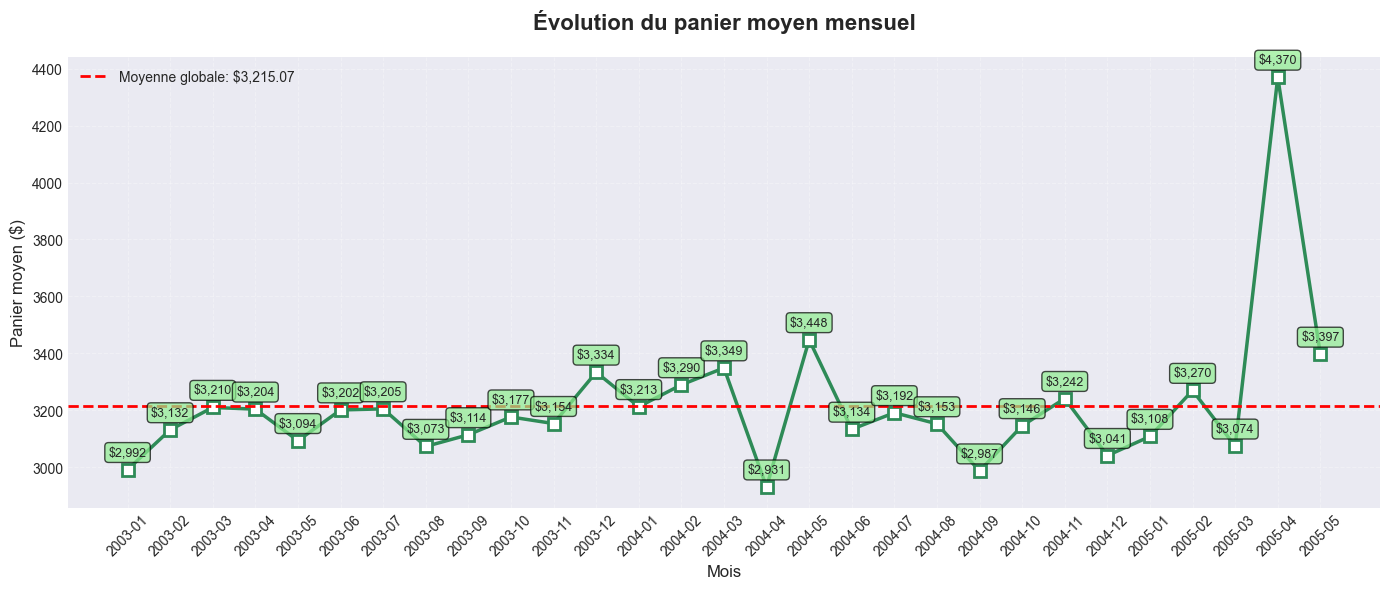


💰 INTERPRÉTATION :
• Panier moyen global : $3,215.07
• Panier médian : $3,176.82
• Panier minimum : $2,930.87
• Panier maximum : $4,369.58
• Coefficient de variation : 0.08 (très stable)


In [7]:
# Cellule 7 : Graphique 3 - Évolution du panier moyen mensuel

if df_mois is not None and len(df_mois) > 0:
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    x = range(len(df_mois))
    
    # Tracé de la courbe
    ax3.plot(x, df_mois['panier_moyen'], 
            marker='s', linewidth=2.5, color='seagreen', 
            markersize=8, markerfacecolor='white', 
            markeredgewidth=2, markeredgecolor='seagreen')
    
    # Ligne de moyenne
    moyenne_globale = df_mois['panier_moyen'].mean()
    ax3.axhline(y=moyenne_globale, color='red', linestyle='--', 
               linewidth=2, label=f'Moyenne globale: ${moyenne_globale:,.2f}')
    
    # Personnalisation
    ax3.set_title('Évolution du panier moyen mensuel', 
                  fontsize=16, fontweight='bold', pad=20)
    ax3.set_xlabel('Mois', fontsize=12)
    ax3.set_ylabel('Panier moyen ($)', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df_mois['mois'], rotation=45, fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.legend(loc='best', fontsize=10)
    
    # Ajout des valeurs
    for i, (mois, pm) in enumerate(zip(df_mois['mois'], df_mois['panier_moyen'])):
        ax3.annotate(f'${pm:,.0f}', (i, pm), textcoords="offset points", 
                   xytext=(0, 10), ha='center', fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    
    viz.safe_plot(fig3, 'evolution_panier_moyen_mensuel.png')
    
    # Interprétation
    print("\n💰 INTERPRÉTATION :")
    print(f"• Panier moyen global : ${df_mois['panier_moyen'].mean():,.2f}")
    print(f"• Panier médian : ${df_mois['panier_moyen'].median():,.2f}")
    print(f"• Panier minimum : ${df_mois['panier_moyen'].min():,.2f}")
    print(f"• Panier maximum : ${df_mois['panier_moyen'].max():,.2f}")
    
    # Volatilité
    ecart_type = df_mois['panier_moyen'].std()
    cv = ecart_type / df_mois['panier_moyen'].mean()
    print(f"• Coefficient de variation : {cv:.2f} ", end="")
    if cv < 0.1:
        print("(très stable)")
    elif cv < 0.2:
        print("(stable)")
    elif cv < 0.3:
        print("(volatilité modérée)")
    else:
        print("(forte volatilité)")

### Graphique 1.4 : Tableau des statistiques temporelles

Ce tableau récapitule l'ensemble des indicateurs temporels clés :
- Indicateurs globaux (période, nombre de mois)
- Statistiques sur le chiffre d'affaires
- Statistiques sur les commandes
- Statistiques sur le panier moyen
- Ratios d'activité

Il offre une vision synthétique de la performance temporelle.

✅ Graphique sauvegardé: visualizations/statistiques_temporelles.png


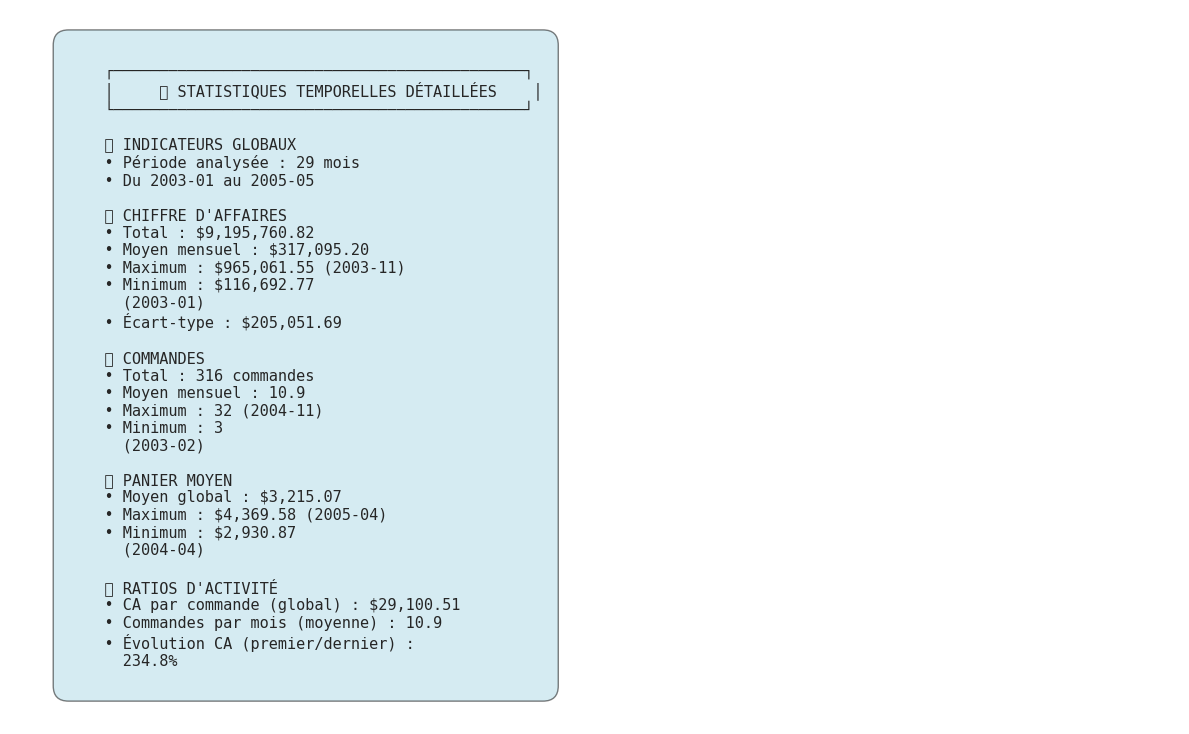

📊 Données sauvegardées: visualizations/donnees_temporelles.csv


In [8]:
# Cellule 8 : Graphique 4 - Tableau des statistiques temporelles

if df_mois is not None and len(df_mois) > 0:
    fig4, ax4 = plt.subplots(figsize=(12, 8))
    ax4.axis('off')
    
    # Calcul des statistiques avancées
    ca_total = df_mois['chiffre_affaires'].sum()
    ca_moyen = df_mois['chiffre_affaires'].mean()
    ca_max_mois = df_mois.loc[df_mois['chiffre_affaires'].idxmax(), 'mois']
    ca_max_valeur = df_mois['chiffre_affaires'].max()
    
    commandes_total = int(df_mois['nombre_commandes'].sum())
    commandes_moyen = df_mois['nombre_commandes'].mean()
    commandes_max_mois = df_mois.loc[df_mois['nombre_commandes'].idxmax(), 'mois']
    commandes_max_valeur = int(df_mois['nombre_commandes'].max())
    
    panier_moyen_global = df_mois['panier_moyen'].mean()
    panier_max_mois = df_mois.loc[df_mois['panier_moyen'].idxmax(), 'mois']
    panier_max_valeur = df_mois['panier_moyen'].max()
    
    # Création du tableau stylisé
    stats_text = f"""
    ┌─────────────────────────────────────────────┐
    │     📊 STATISTIQUES TEMPORELLES DÉTAILLÉES    │
    └─────────────────────────────────────────────┘
    
    📈 INDICATEURS GLOBAUX
    • Période analysée : {len(df_mois)} mois
    • Du {df_mois['mois'].iloc[0]} au {df_mois['mois'].iloc[-1]}
    
    💰 CHIFFRE D'AFFAIRES
    • Total : ${ca_total:,.2f}
    • Moyen mensuel : ${ca_moyen:,.2f}
    • Maximum : ${ca_max_valeur:,.2f} ({ca_max_mois})
    • Minimum : ${df_mois['chiffre_affaires'].min():,.2f} 
      ({df_mois.loc[df_mois['chiffre_affaires'].idxmin(), 'mois']})
    • Écart-type : ${df_mois['chiffre_affaires'].std():,.2f}
    
    📦 COMMANDES
    • Total : {commandes_total:,} commandes
    • Moyen mensuel : {commandes_moyen:.1f}
    • Maximum : {commandes_max_valeur} ({commandes_max_mois})
    • Minimum : {int(df_mois['nombre_commandes'].min())} 
      ({df_mois.loc[df_mois['nombre_commandes'].idxmin(), 'mois']})
    
    🛒 PANIER MOYEN
    • Moyen global : ${panier_moyen_global:,.2f}
    • Maximum : ${panier_max_valeur:,.2f} ({panier_max_mois})
    • Minimum : ${df_mois['panier_moyen'].min():,.2f} 
      ({df_mois.loc[df_mois['panier_moyen'].idxmin(), 'mois']})
    
    📊 RATIOS D'ACTIVITÉ
    • CA par commande (global) : ${ca_total/commandes_total:,.2f}
    • Commandes par mois (moyenne) : {commandes_moyen:.1f}
    • Évolution CA (premier/dernier) : 
      {((df_mois['chiffre_affaires'].iloc[-1] / df_mois['chiffre_affaires'].iloc[0] - 1) * 100):.1f}%
    """
    
    # Ajout du texte avec mise en forme
    ax4.text(0.05, 0.95, stats_text, fontsize=11, 
            verticalalignment='top', fontfamily='monospace',
            transform=ax4.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5, pad=1))
    
    viz.safe_plot(fig4, 'statistiques_temporelles.png')
    
    # Sauvegarde des données
    df_mois.to_csv(f'{viz.output_dir}/donnees_temporelles.csv', index=False)
    print(f"📊 Données sauvegardées: {viz.output_dir}/donnees_temporelles.csv")

# PARTIE 2 : ANALYSE DE LA RÉPARTITION GÉOGRAPHIQUE

## Objectif de l'analyse

L'analyse géographique permet de comprendre la distribution des clients et du chiffre d'affaires à travers le monde. Nous allons examiner :

1. **Les pays générant le plus de chiffre d'affaires**
2. **Les pays avec le plus de clients**
3. **La concentration du CA par pays** (camembert)
4. **La relation entre nombre de clients et chiffre d'affaires**

Cette analyse est cruciale pour orienter les efforts marketing et commerciaux vers les marchés les plus porteurs.

## Requête SQL utilisée

```sql
SELECT 
    c.country,
    COUNT(DISTINCT c.customerNumber) AS nombre_clients,
    COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
    SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
    AVG(od.quantityOrdered * od.priceEach) AS panier_moyen
FROM customers c
LEFT JOIN orders o ON c.customerNumber = o.customerNumber
LEFT JOIN orderdetails od ON o.orderNumber = od.orderNumber
WHERE o.status NOT IN ('Cancelled', 'On Hold') OR o.orderNumber IS NULL
GROUP BY c.country
HAVING COUNT(DISTINCT c.customerNumber) > 0
ORDER BY chiffre_affaires DESC

In [9]:

# Cellule 9 : Extraction des données géographiques

def repartition_geographique(viz):
    """Analyse géographique"""
    print("🌍 Génération des graphiques géographiques...")
    
    query = """
    SELECT 
        c.country,
        COUNT(DISTINCT c.customerNumber) AS nombre_clients,
        COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
        SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
        AVG(od.quantityOrdered * od.priceEach) AS panier_moyen
    FROM customers c
    LEFT JOIN orders o ON c.customerNumber = o.customerNumber
    LEFT JOIN orderdetails od ON o.orderNumber = od.orderNumber
    WHERE o.status NOT IN ('Cancelled', 'On Hold') OR o.orderNumber IS NULL
    GROUP BY c.country
    HAVING COUNT(DISTINCT c.customerNumber) > 0
    ORDER BY chiffre_affaires DESC
    """
    
    df = viz.execute_query(query)
    
    if df.empty:
        print("❌ Aucune donnée géographique trouvée")
        return None
    
    # Conversion numérique
    df = viz.convert_to_numeric(df,
        ['nombre_clients', 'nombre_commandes', 'chiffre_affaires', 'panier_moyen'])
    df = df.fillna(0)
    
    return df

# Exécution
df_geo = repartition_geographique(viz)

if df_geo is not None:
    print(f"\n✅ {len(df_geo)} pays avec clients")
    print(f"   • {len(df_geo[df_geo['chiffre_affaires'] > 0])} pays avec ventes")
    print("\n📋 Aperçu des données (Top 5 par CA) :")
    display(df_geo.head())

🌍 Génération des graphiques géographiques...

✅ 28 pays avec clients
   • 22 pays avec ventes

📋 Aperçu des données (Top 5 par CA) :


,country,nombre_clients,nombre_commandes,chiffre_affaires,panier_moyen
0,USA,36,108,3085273.40,3240.833403
1,Spain,7,35,1052323.73,3227.986902
2,France,12,37,1007374.02,3208.197516
3,Australia,5,19,562582.59,3040.986973
4,New Zealand,4,13,416114.03,3200.877154


### Graphique 2.1 : Top 10 pays par chiffre d'affaires

Ce graphique en barres horizontales classe les 10 pays qui génèrent le plus de chiffre d'affaires.
Les couleurs dégradées (viridis) permettent de visualiser la hiérarchie :
- Le pays en tête de liste est celui qui contribue le plus au CA total
- L'écart entre le premier et le dixième indique le niveau de concentration

Les valeurs affichées sur les barres montrent :
- Le CA en milliers de dollars (K$) pour faciliter la lecture
- Le pourcentage que représente chaque pays dans le top 10

✅ Graphique sauvegardé: visualizations/top_pays_ca.png


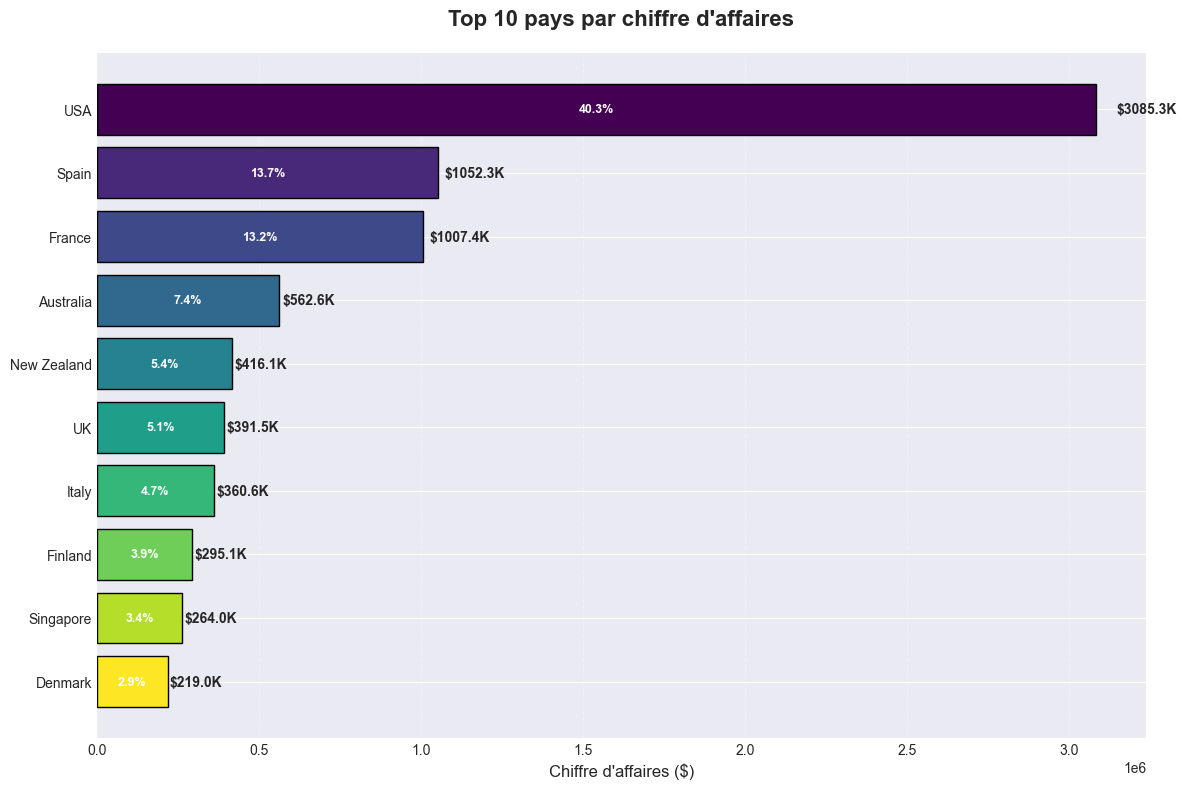


🌍 INTERPRÉTATION - TOP 10 PAYS PAR CA :
Les 10 premiers pays représentent $7653.9K de CA
🏆 Pays leader : USA avec $3085.3K
📉 10ème pays : Denmark avec $219.0K
📊 Écart leader/10ème : 14.1x
🎯 Les 3 premiers pays concentrent 67.2% du CA des top 10
   → Forte concentration (risque de dépendance à quelques marchés)


In [10]:
# Cellule 10 : Graphique 5 - Top 10 pays par CA

if df_geo is not None and len(df_geo) > 0:
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    
    # Sélection des top 10
    df_top10 = df_geo.nlargest(10, 'chiffre_affaires')
    
    # Création du barplot horizontal
    colors = plt.cm.viridis(np.linspace(0, 1, len(df_top10)))
    bars = ax1.barh(df_top10['country'], df_top10['chiffre_affaires'], 
                   color=colors, edgecolor='black', linewidth=1)
    
    # Personnalisation
    ax1.set_title('Top 10 pays par chiffre d\'affaires', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Chiffre d\'affaires ($)', fontsize=12)
    ax1.invert_yaxis()  # Pour avoir le plus grand en haut
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    # Ajout des valeurs
    total_ca = df_top10['chiffre_affaires'].sum()
    for i, (bar, ca, country) in enumerate(zip(bars, df_top10['chiffre_affaires'], 
                                                df_top10['country'])):
        # Valeur en K$
        ax1.text(ca + ca*0.02, i, f'${ca/1000:.1f}K', 
                va='center', fontsize=10, fontweight='bold')
        
        # Pourcentage du total des top 10
        pct = (ca / total_ca) * 100
        ax1.text(ca/2, i, f'{pct:.1f}%', 
                va='center', ha='center', fontsize=9,
                color='white', fontweight='bold')
    
    viz.safe_plot(fig1, 'top_pays_ca.png')
    
    # Interprétation
    print("\n🌍 INTERPRÉTATION - TOP 10 PAYS PAR CA :")
    print(f"Les 10 premiers pays représentent ${total_ca/1000:.1f}K de CA")
    print(f"🏆 Pays leader : {df_top10.iloc[0]['country']} avec ${df_top10.iloc[0]['chiffre_affaires']/1000:.1f}K")
    print(f"📉 10ème pays : {df_top10.iloc[-1]['country']} avec ${df_top10.iloc[-1]['chiffre_affaires']/1000:.1f}K")
    
    # Écart et concentration
    ratio = df_top10.iloc[0]['chiffre_affaires'] / df_top10.iloc[-1]['chiffre_affaires']
    print(f"📊 Écart leader/10ème : {ratio:.1f}x")
    
    pct_top3 = (df_top10.iloc[0:3]['chiffre_affaires'].sum() / total_ca) * 100
    print(f"🎯 Les 3 premiers pays concentrent {pct_top3:.1f}% du CA des top 10")
    
    if pct_top3 > 60:
        print("   → Forte concentration (risque de dépendance à quelques marchés)")
    elif pct_top3 > 40:
        print("   → Concentration modérée")
    else:
        print("   → Bonne diversification géographique")

### Graphique 2.2 : Top 10 pays par nombre de clients

Ce graphique complète le précédent en montrant la répartition des clients par pays.
Il permet de comparer :
- Les pays avec beaucoup de clients mais peu de CA (marchés de volume)
- Les pays avec peu de clients mais beaucoup de CA (marchés de valeur)

Les couleurs plasma mettent en évidence la hiérarchie des effectifs clients.

✅ Graphique sauvegardé: visualizations/top10_pays_clients.png


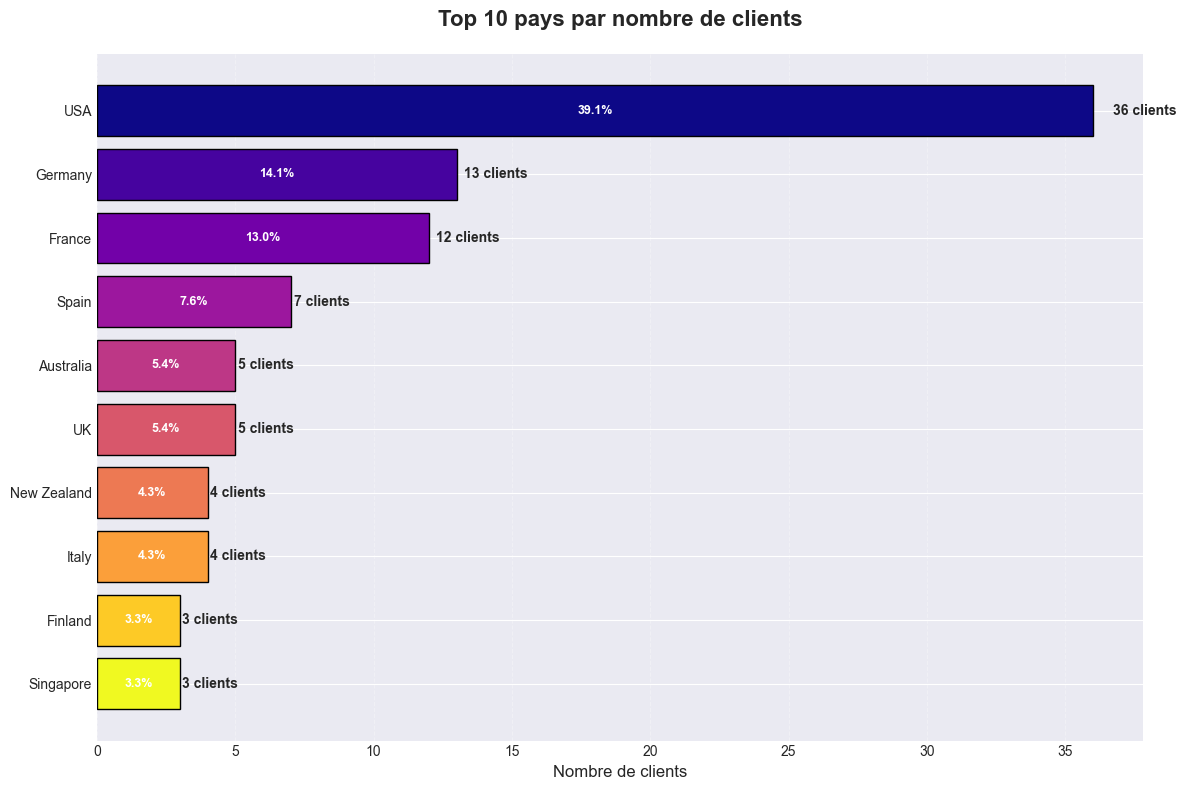


👥 INTERPRÉTATION - TOP 10 PAYS PAR CLIENTS :
Les 10 premiers pays concentrent 92 clients
🏆 Pays avec le plus de clients : USA (36 clients)

🔄 Comparaison avec le classement CA :
Pays communs dans les top 5 CA et top 5 clients : 4
   → France, USA, Spain, Australia (marchés clés)
   → New Zealand : fort CA mais hors top 5 clients (clients à forte valeur)
   → Germany : beaucoup de clients mais CA modéré (potentiel de croissance)


In [11]:
# Cellule 11 : Graphique 6 - Top 10 pays par nombre de clients

if df_geo is not None and len(df_geo) > 0:
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    
    # Sélection des top 10 par nombre de clients
    df_top10_clients = df_geo.nlargest(10, 'nombre_clients')
    
    # Création du barplot horizontal
    colors = plt.cm.plasma(np.linspace(0, 1, len(df_top10_clients)))
    bars = ax2.barh(df_top10_clients['country'], df_top10_clients['nombre_clients'], 
                   color=colors, edgecolor='black', linewidth=1)
    
    # Personnalisation
    ax2.set_title('Top 10 pays par nombre de clients', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Nombre de clients', fontsize=12)
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    # Ajout des valeurs
    total_clients = df_top10_clients['nombre_clients'].sum()
    for i, (bar, clients, country) in enumerate(zip(bars, df_top10_clients['nombre_clients'], 
                                                    df_top10_clients['country'])):
        ax2.text(clients + clients*0.02, i, f'{int(clients)} clients', 
                va='center', fontsize=10, fontweight='bold')
        
        # Pourcentage du total
        pct = (clients / total_clients) * 100
        ax2.text(clients/2, i, f'{pct:.1f}%', 
                va='center', ha='center', fontsize=9,
                color='white', fontweight='bold')
    
    viz.safe_plot(fig2, 'top10_pays_clients.png')
    
    # Interprétation
    print("\n👥 INTERPRÉTATION - TOP 10 PAYS PAR CLIENTS :")
    print(f"Les 10 premiers pays concentrent {int(total_clients)} clients")
    print(f"🏆 Pays avec le plus de clients : {df_top10_clients.iloc[0]['country']} ({int(df_top10_clients.iloc[0]['nombre_clients'])} clients)")
    
    # Comparaison avec le classement CA
    print("\n🔄 Comparaison avec le classement CA :")
    top_ca = set(df_top10['country'].head(5))
    top_clients_set = set(df_top10_clients['country'].head(5))
    communs = top_ca.intersection(top_clients_set)
    print(f"Pays communs dans les top 5 CA et top 5 clients : {len(communs)}")
    if communs:
        print(f"   → {', '.join(communs)} (marchés clés)")
    
    # Analyse des écarts
    for pays in top_ca - top_clients_set:
        print(f"   → {pays} : fort CA mais hors top 5 clients (clients à forte valeur)")
    for pays in top_clients_set - top_ca:
        print(f"   → {pays} : beaucoup de clients mais CA modéré (potentiel de croissance)")

### Graphique 2.3 : Répartition du CA par pays (camembert)

Ce diagramme circulaire montre la part de chaque pays dans le chiffre d'affaires total.
Il permet de visualiser :
- La part du leader (s'il est dominant ou non)
- La répartition entre les 5 premiers et les "autres"
- Le niveau de concentration géographique du CA

Les couleurs vives (Set3) facilitent la distinction des différentes parts.

✅ Graphique sauvegardé: visualizations/repartition_ca_pays.png


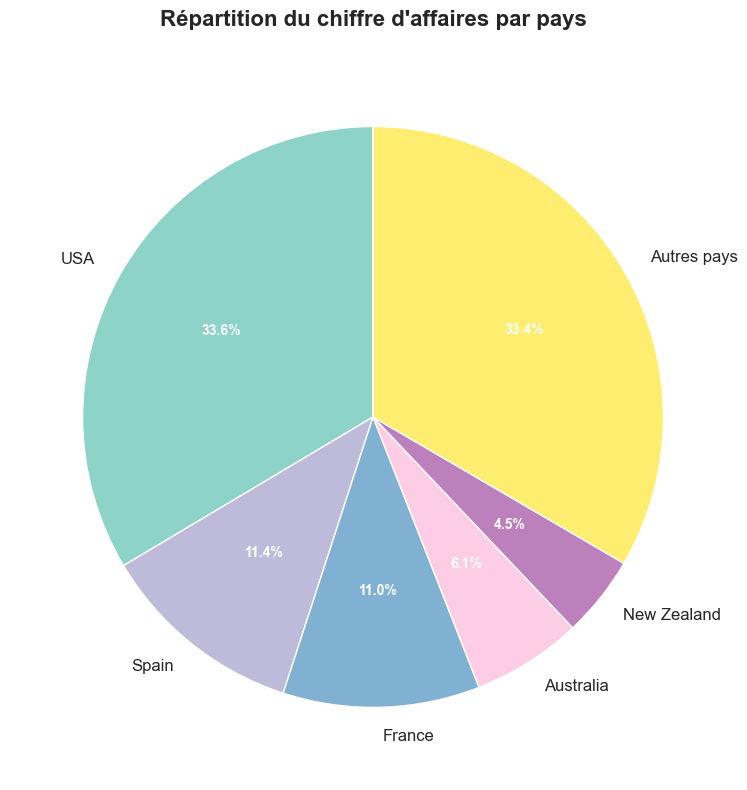


🥧 INTERPRÉTATION - RÉPARTITION GÉOGRAPHIQUE :
🌍 CA total : $9,195,760.82
📊 Les 5 premiers pays représentent 66.6% du CA total
🏆 Le pays leader (USA) représente 33.6% du CA
🌐 Les 23 autres pays se partagent 33.4%

📊 Indice de concentration de Herfindahl : 0.152
   → Concentration modérée


In [12]:
# Cellule 12 : Graphique 7 - Répartition du CA par pays (camembert)

if df_geo is not None and df_geo['chiffre_affaires'].sum() > 0:
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    
    # Préparation des données
    ca_total = df_geo['chiffre_affaires'].sum()
    df_top5 = df_geo.nlargest(5, 'chiffre_affaires')
    autres = max(0, ca_total - df_top5['chiffre_affaires'].sum())
    
    valeurs = df_top5['chiffre_affaires'].tolist() + [autres]
    labels = df_top5['country'].tolist() + ['Autres pays']
    
    # Création du camembert
    colors = plt.cm.Set3(np.linspace(0, 1, len(valeurs)))
    wedges, texts, autotexts = ax3.pie(
        valeurs, 
        labels=labels,
        autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
    
    # Personnalisation
    ax3.set_title('Répartition du chiffre d\'affaires par pays', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Style des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    viz.safe_plot(fig3, 'repartition_ca_pays.png')
    
    # Interprétation
    print("\n🥧 INTERPRÉTATION - RÉPARTITION GÉOGRAPHIQUE :")
    print(f"🌍 CA total : ${ca_total:,.2f}")
    
    pct_top5 = ((ca_total - autres) / ca_total * 100)
    print(f"📊 Les 5 premiers pays représentent {pct_top5:.1f}% du CA total")
    print(f"🏆 Le pays leader ({df_top5.iloc[0]['country']}) représente {(df_top5.iloc[0]['chiffre_affaires']/ca_total*100):.1f}% du CA")
    
    if autres > 0:
        print(f"🌐 Les {len(df_geo) - 5} autres pays se partagent {(autres/ca_total*100):.1f}%")
    
    # Indice de concentration (Herfindahl simplifié)
    herfindahl = sum((df_geo['chiffre_affaires']/ca_total)**2)
    print(f"\n📊 Indice de concentration de Herfindahl : {herfindahl:.3f}")
    if herfindahl > 0.25:
        print("   → Très forte concentration (risque géographique élevé)")
    elif herfindahl > 0.15:
        print("   → Concentration modérée")
    else:
        print("   → Portefeuille géographique diversifié")

### Graphique 2.4 : Relation clients vs chiffre d'affaires par pays

Ce nuage de points (scatter plot) met en relation le nombre de clients et le chiffre d'affaires par pays.
Chaque point représente un pays, avec :
- La taille : proportionnelle au nombre de commandes
- La couleur : correspond au panier moyen
- La position : indique le positionnement du marché

Les lignes de moyenne divisent le graphique en 4 quadrants stratégiques.

✅ Graphique sauvegardé: visualizations/relation_clients_ca_pays.png


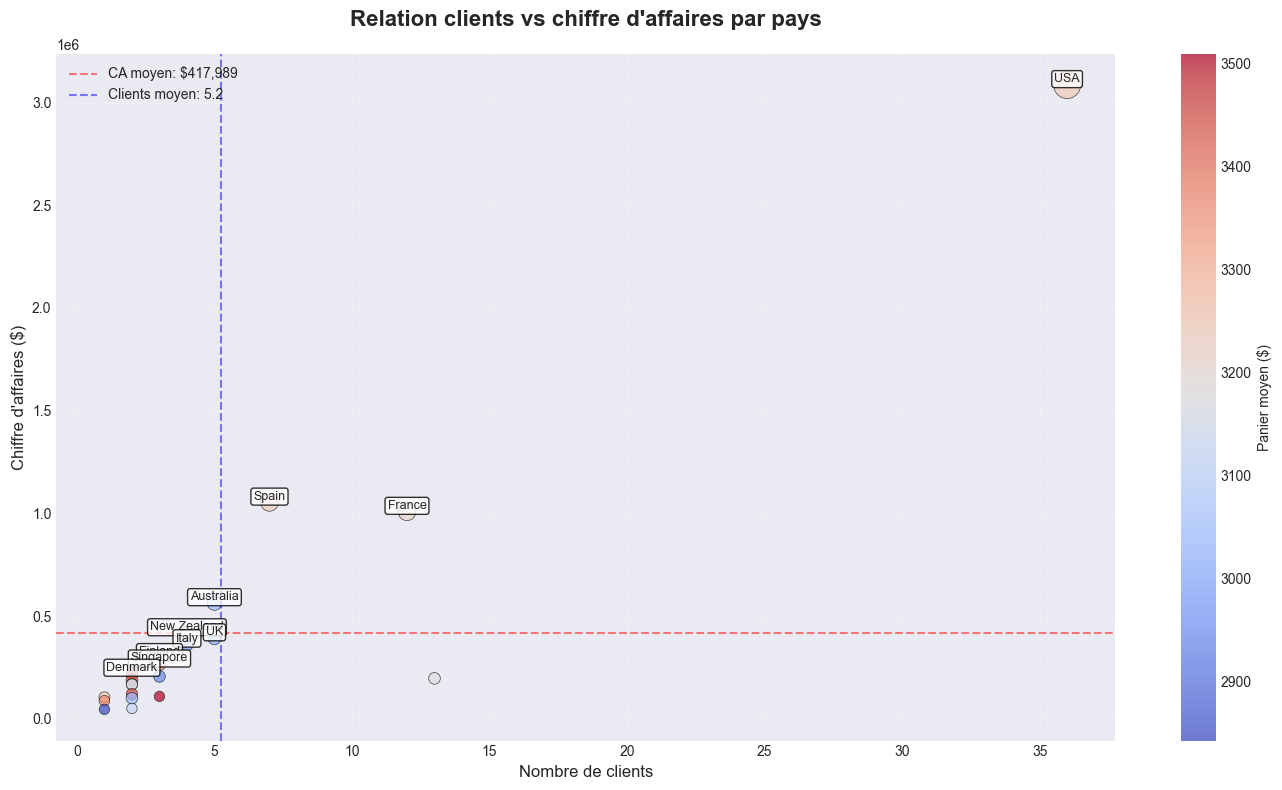


📈 INTERPRÉTATION - MATRICE STRATÉGIQUE :

🔵 MARCHÉS STARS (clients nombreux + CA élevé) : 3 pays
   • USA : 36 clients, $3085.3K CA
   • Spain : 7 clients, $1052.3K CA
   • France : 12 clients, $1007.4K CA

🟢 MARCHÉS À FORT POTENTIEL (peu de clients mais CA élevé) : 1 pays
   • Australia : 5 clients, $562.6K CA

🟡 MARCHÉS SOUS-EXPLOITÉS (beaucoup de clients mais CA faible) : 1 pays
   • Germany : 13 clients, $196.5K CA

🔴 MARCHÉS À DÉVELOPPER (faible présence) : 17 pays

📊 Corrélation clients/CA : 0.938
   → Forte corrélation positive (logique commerciale classique)

📊 Données sauvegardées: visualizations/donnees_geographiques.csv


In [13]:
# Cellule 13 : Graphique 8 - Relation clients vs CA par pays

if df_geo is not None and len(df_geo) > 0:
    fig4, ax4 = plt.subplots(figsize=(14, 8))
    
    # Filtrage des pays avec CA > 0
    mask = (df_geo['chiffre_affaires'] > 0) & (df_geo['nombre_clients'] > 0)
    df_plot = df_geo[mask].copy()
    
    if len(df_plot) > 0:
        # Création du scatter plot
        scatter = ax4.scatter(df_plot['nombre_clients'], df_plot['chiffre_affaires'],
                            c=df_plot['panier_moyen'], 
                            s=df_plot['nombre_commandes']*3 + 50,
                            alpha=0.7, cmap='coolwarm', 
                            edgecolors='black', linewidth=0.5)
        
        # Ajout des lignes de moyenne
        ax4.axhline(y=df_plot['chiffre_affaires'].mean(), color='red', 
                   linestyle='--', alpha=0.5, 
                   label=f"CA moyen: ${df_plot['chiffre_affaires'].mean():,.0f}")
        ax4.axvline(x=df_plot['nombre_clients'].mean(), color='blue', 
                   linestyle='--', alpha=0.5, 
                   label=f"Clients moyen: {df_plot['nombre_clients'].mean():.1f}")
        
        # Personnalisation
        ax4.set_xlabel('Nombre de clients', fontsize=12)
        ax4.set_ylabel('Chiffre d\'affaires ($)', fontsize=12)
        ax4.set_title('Relation clients vs chiffre d\'affaires par pays', 
                     fontsize=16, fontweight='bold', pad=20)
        ax4.grid(True, alpha=0.3, linestyle='--')
        
        # Ajout des noms des pays (pour les principaux)
        for i, row in df_plot.nlargest(10, 'chiffre_affaires').iterrows():
            ax4.annotate(row['country'], 
                       (row['nombre_clients'], row['chiffre_affaires']),
                       fontsize=9, ha='center', va='bottom',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
        
        # Barre de couleur
        cbar = plt.colorbar(scatter, ax=ax4, label='Panier moyen ($)')
        cbar.ax.tick_params(labelsize=10)
        
        # Légende
        ax4.legend(loc='upper left', fontsize=10)
        
        viz.safe_plot(fig4, 'relation_clients_ca_pays.png')
        
        # Interprétation des quadrants
        print("\n📈 INTERPRÉTATION - MATRICE STRATÉGIQUE :")
        
        ca_moyen = df_plot['chiffre_affaires'].mean()
        clients_moyen = df_plot['nombre_clients'].mean()
        
        # Quadrant 1 : Beaucoup de clients, CA élevé
        q1 = df_plot[(df_plot['nombre_clients'] > clients_moyen) & 
                     (df_plot['chiffre_affaires'] > ca_moyen)]
        if len(q1) > 0:
            print(f"\n🔵 MARCHÉS STARS (clients nombreux + CA élevé) : {len(q1)} pays")
            for _, row in q1.head(3).iterrows():
                print(f"   • {row['country']} : {int(row['nombre_clients'])} clients, ${row['chiffre_affaires']/1000:.1f}K CA")
        
        # Quadrant 2 : Peu de clients, CA élevé
        q2 = df_plot[(df_plot['nombre_clients'] <= clients_moyen) & 
                     (df_plot['chiffre_affaires'] > ca_moyen)]
        if len(q2) > 0:
            print(f"\n🟢 MARCHÉS À FORT POTENTIEL (peu de clients mais CA élevé) : {len(q2)} pays")
            for _, row in q2.head(3).iterrows():
                print(f"   • {row['country']} : {int(row['nombre_clients'])} clients, ${row['chiffre_affaires']/1000:.1f}K CA")
        
        # Quadrant 3 : Beaucoup de clients, CA faible
        q3 = df_plot[(df_plot['nombre_clients'] > clients_moyen) & 
                     (df_plot['chiffre_affaires'] <= ca_moyen)]
        if len(q3) > 0:
            print(f"\n🟡 MARCHÉS SOUS-EXPLOITÉS (beaucoup de clients mais CA faible) : {len(q3)} pays")
            for _, row in q3.head(3).iterrows():
                print(f"   • {row['country']} : {int(row['nombre_clients'])} clients, ${row['chiffre_affaires']/1000:.1f}K CA")
        
        # Quadrant 4 : Peu de clients, CA faible
        q4 = df_plot[(df_plot['nombre_clients'] <= clients_moyen) & 
                     (df_plot['chiffre_affaires'] <= ca_moyen)]
        if len(q4) > 0:
            print(f"\n🔴 MARCHÉS À DÉVELOPPER (faible présence) : {len(q4)} pays")
        
        # Corrélation
        corr = df_plot['nombre_clients'].corr(df_plot['chiffre_affaires'])
        print(f"\n📊 Corrélation clients/CA : {corr:.3f}")
        if corr > 0.7:
            print("   → Forte corrélation positive (logique commerciale classique)")
        elif corr > 0.4:
            print("   → Corrélation modérée")
        else:
            print("   → Faible corrélation (d'autres facteurs comme le panier moyen sont déterminants)")
    
    # Sauvegarde des données
    df_geo.to_csv(f'{viz.output_dir}/donnees_geographiques.csv', index=False)
    print(f"\n📊 Données sauvegardées: {viz.output_dir}/donnees_geographiques.csv")

# PARTIE 3 : ANALYSE DES VENTES PAR GAMME DE PRODUITS

## Objectif de l'analyse

L'analyse par gamme de produits permet de comprendre la performance de chaque catégorie. Nous allons examiner :

1. **Le chiffre d'affaires par gamme** : quelles gammes génèrent le plus de revenus ?
2. **La répartition du CA** : concentration ou diversification ?
3. **Les quantités vendues** : corrélation avec le CA ?
4. **La relation prix vs quantité** : élasticité par gamme

Cette analyse est essentielle pour orienter les décisions d'achat, de stock et de marketing.

## Requête SQL utilisée

```sql
SELECT 
    pl.productLine AS gamme,
    COUNT(DISTINCT od.productCode) AS nombre_produits,
    SUM(od.quantityOrdered) AS quantite_vendue,
    SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
    AVG(od.priceEach) AS prix_moyen,
    COUNT(DISTINCT o.customerNumber) AS nombre_clients,
    COUNT(DISTINCT o.orderNumber) AS nombre_commandes
FROM productlines pl
JOIN products p ON pl.productLine = p.productLine
JOIN orderdetails od ON p.productCode = od.productCode
JOIN orders o ON od.orderNumber = o.orderNumber
WHERE o.status NOT IN ('Cancelled', 'On Hold')
GROUP BY pl.productLine
ORDER BY chiffre_affaires DESC

In [14]:

# Cellule 14 : Extraction des données par gamme

def ventes_par_gamme(viz):
    """Analyse des ventes par gamme de produits"""
    print("📊 Génération des graphiques par gamme de produits...")
    
    query = """
    SELECT 
        pl.productLine AS gamme,
        COUNT(DISTINCT od.productCode) AS nombre_produits,
        SUM(od.quantityOrdered) AS quantite_vendue,
        SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
        AVG(od.priceEach) AS prix_moyen,
        COUNT(DISTINCT o.customerNumber) AS nombre_clients,
        COUNT(DISTINCT o.orderNumber) AS nombre_commandes
    FROM productlines pl
    JOIN products p ON pl.productLine = p.productLine
    JOIN orderdetails od ON p.productCode = od.productCode
    JOIN orders o ON od.orderNumber = o.orderNumber
    WHERE o.status NOT IN ('Cancelled', 'On Hold')
    GROUP BY pl.productLine
    ORDER BY chiffre_affaires DESC
    """
    
    df = viz.execute_query(query)
    
    if df.empty:
        print("❌ Aucune donnée de gamme trouvée")
        return None
    
    # Conversion numérique
    df = viz.convert_to_numeric(df,
        ['nombre_produits', 'quantite_vendue', 'chiffre_affaires', 
         'prix_moyen', 'nombre_clients', 'nombre_commandes'])
    df = df.fillna(0)
    
    return df

# Exécution
df_gamme = ventes_par_gamme(viz)

if df_gamme is not None:
    print(f"\n✅ {len(df_gamme)} gammes de produits")
    print("\n📋 Aperçu des données :")
    display(df_gamme)

📊 Génération des graphiques par gamme de produits...

✅ 7 gammes de produits

📋 Aperçu des données :


,gamme,nombre_produits,quantite_vendue,chiffre_affaires,prix_moyen,nombre_clients,nombre_commandes
0,Classic Cars,37,34381.0,3724204.52,107.925814,94,202
1,Vintage Cars,24,21933.0,1717386.28,78.284241,89,179
2,Motorcycles,13,12684.0,1113502.03,87.339272,55,77
3,Trucks and Buses,11,10830.0,1007426.26,92.678618,49,74
4,Planes,12,10842.0,869810.90,80.330259,50,62
5,Ships,9,7567.0,588400.06,77.697385,48,63
6,Trains,3,2651.0,175030.77,66.481053,34,44


### Graphique 3.1 : Chiffre d'affaires par gamme de produits

Ce diagramme en barres montre le CA généré par chaque gamme de produits.
Il permet d'identifier :
- La gamme leader (celle qui génère le plus de revenus)
- Les gammes secondaires
- L'écart entre la première et les suivantes

Les couleurs vives (Set3) facilitent la distinction entre les différentes gammes.

✅ Graphique sauvegardé: visualizations/ca_par_gamme.png


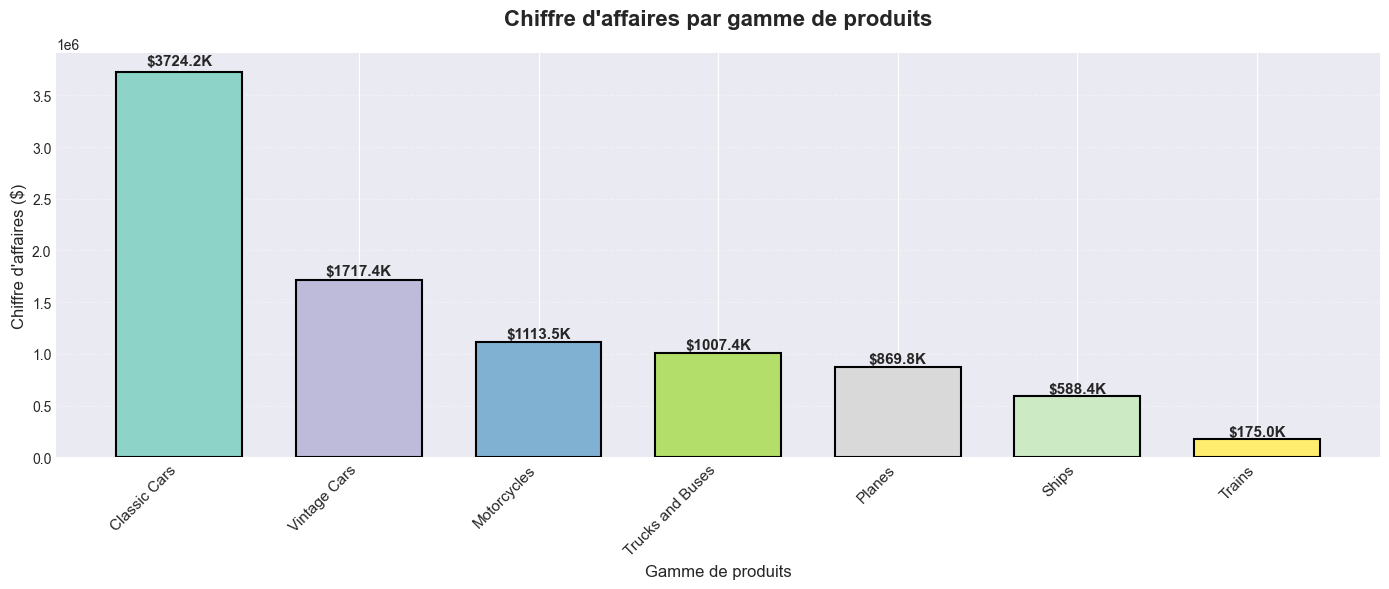


📊 INTERPRÉTATION - CA PAR GAMME :
🏆 Gamme leader : Classic Cars
   • CA : $3,724,204.52
   • Part du CA total : 40.5%
📉 Gamme la moins performante : Trains
   • CA : $175,030.77
   • Part du CA total : 1.9%
📐 Écart leader/dernier : 21.3x
🎯 Les 3 premières gammes concentrent 71.3% du CA


In [15]:
# Cellule 15 : Graphique 9 - CA par gamme

if df_gamme is not None and len(df_gamme) > 0:
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    
    # Préparation des données
    x_pos = np.arange(len(df_gamme))
    colors_bar = plt.cm.Set3(np.linspace(0, 1, len(df_gamme)))
    
    # Création du barplot
    bars = ax1.bar(x_pos, df_gamme['chiffre_affaires'], 
                  color=colors_bar, edgecolor='black', linewidth=1.5, width=0.7)
    
    # Personnalisation
    ax1.set_title('Chiffre d\'affaires par gamme de produits', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Gamme de produits', fontsize=12)
    ax1.set_ylabel('Chiffre d\'affaires ($)', fontsize=12)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_gamme['gamme'], rotation=45, ha='right', fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, df_gamme['chiffre_affaires']):
        if value > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., 
                   bar.get_height() + bar.get_height()*0.01,
                   f'${value/1000:.1f}K', 
                   ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    viz.safe_plot(fig1, 'ca_par_gamme.png')
    
    # Interprétation
    print("\n📊 INTERPRÉTATION - CA PAR GAMME :")
    ca_total = df_gamme['chiffre_affaires'].sum()
    
    # Gamme leader
    gamme_leader = df_gamme.loc[df_gamme['chiffre_affaires'].idxmax()]
    print(f"🏆 Gamme leader : {gamme_leader['gamme']}")
    print(f"   • CA : ${gamme_leader['chiffre_affaires']:,.2f}")
    print(f"   • Part du CA total : {gamme_leader['chiffre_affaires']/ca_total*100:.1f}%")
    
    # Gamme la moins performante
    gamme_min = df_gamme.loc[df_gamme['chiffre_affaires'].idxmin()]
    print(f"📉 Gamme la moins performante : {gamme_min['gamme']}")
    print(f"   • CA : ${gamme_min['chiffre_affaires']:,.2f}")
    print(f"   • Part du CA total : {gamme_min['chiffre_affaires']/ca_total*100:.1f}%")
    
    # Écart
    ratio_max_min = gamme_leader['chiffre_affaires'] / gamme_min['chiffre_affaires']
    print(f"📐 Écart leader/dernier : {ratio_max_min:.1f}x")
    
    # Concentration
    top3_pct = df_gamme.nlargest(3, 'chiffre_affaires')['chiffre_affaires'].sum() / ca_total * 100
    print(f"🎯 Les 3 premières gammes concentrent {top3_pct:.1f}% du CA")

### Graphique 3.2 : Répartition du CA par gamme (camembert)

Ce diagramme circulaire complète le précédent en montrant la part de chaque gamme dans le CA total.
Il permet de visualiser :
- La dominance éventuelle d'une gamme
- La diversification du portefeuille produits
- Les gammes marginales

Les pourcentages en blanc facilitent la lecture des proportions.

✅ Graphique sauvegardé: visualizations/repartition_ca_gamme.png


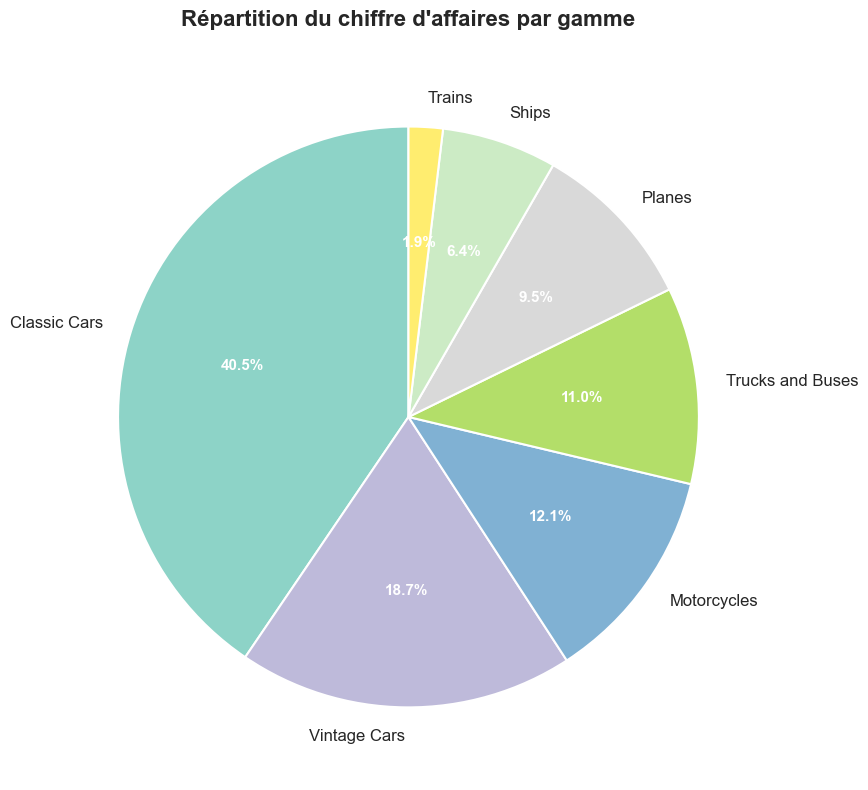


🥧 INTERPRÉTATION - RÉPARTITION PAR GAMME :
📊 Indice de concentration (Herfindahl) : 0.239
   → Concentration modérée

🎯 Principe de Pareto : 3 gammes (42.9%) génèrent 71.3% du CA


In [16]:
# Cellule 16 : Graphique 10 - Répartition du CA par gamme

if df_gamme is not None and df_gamme['chiffre_affaires'].sum() > 0:
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Création du camembert
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(df_gamme)))
    wedges, texts, autotexts = ax2.pie(
        df_gamme['chiffre_affaires'], 
        labels=df_gamme['gamme'],
        autopct=lambda pct: f'{pct:.1f}%',
        startangle=90,
        colors=colors_pie,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
    )
    
    # Personnalisation
    ax2.set_title('Répartition du chiffre d\'affaires par gamme', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Style des pourcentages
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    viz.safe_plot(fig2, 'repartition_ca_gamme.png')
    
    # Interprétation
    print("\n🥧 INTERPRÉTATION - RÉPARTITION PAR GAMME :")
    ca_total = df_gamme['chiffre_affaires'].sum()
    
    # Analyse de la diversification
    nb_gammes = len(df_gamme)
    herfindahl = sum((df_gamme['chiffre_affaires']/ca_total)**2)
    print(f"📊 Indice de concentration (Herfindahl) : {herfindahl:.3f}")
    if herfindahl > 0.3:
        print("   → Forte concentration (risque si une gamme faiblit)")
    elif herfindahl > 0.18:
        print("   → Concentration modérée")
    else:
        print("   → Portefeuille diversifié")
    
    # Seuil des 80/20 (Pareto)
    df_sorted = df_gamme.sort_values('chiffre_affaires', ascending=False)
    cumsum_pct = (df_sorted['chiffre_affaires'].cumsum() / ca_total * 100)
    nb_pareto = (cumsum_pct <= 80).sum()
    pct_pareto = cumsum_pct.iloc[nb_pareto-1] if nb_pareto > 0 else 0
    print(f"\n🎯 Principe de Pareto : {nb_pareto} gammes ({nb_pareto/len(df_gamme)*100:.1f}%) génèrent {pct_pareto:.1f}% du CA")

### Graphique 3.3 : Quantités vendues par gamme

Ce graphique en barres horizontales montre les volumes de vente par gamme.
Il permet de comparer :
- Les gammes à fort volume (ventes nombreuses)
- Les gammes à faible volume (ventes plus rares)
- La cohérence avec le classement CA

Les couleurs pastel (Pastel1) offrent une visualisation agréable des volumes.

✅ Graphique sauvegardé: visualizations/quantites_par_gamme.png


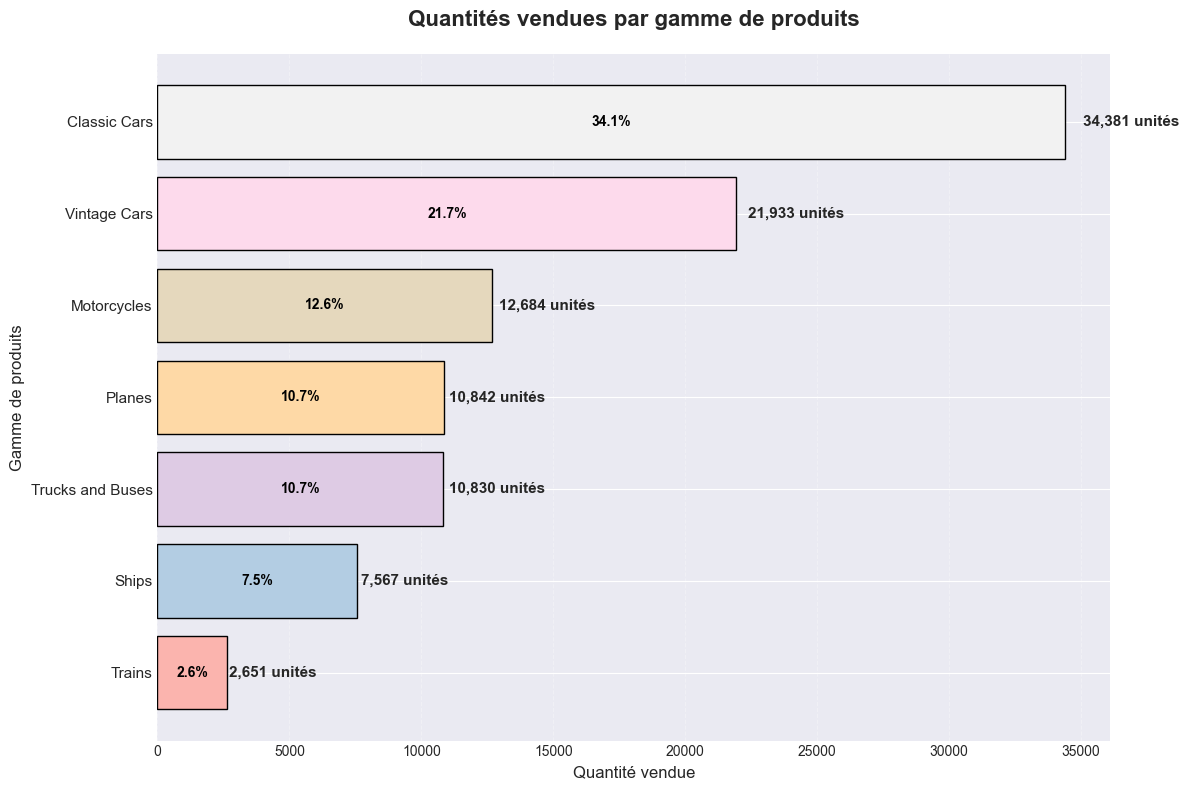


📦 INTERPRÉTATION - VOLUMES DE VENTE :
Total des unités vendues : 100,888
🏆 Gamme la plus vendue : Classic Cars
   • Quantité : 34,381 unités
   • Part des ventes : 34.1%

🔄 Analyse Prix/Volume :
✨ Gammes premium (prix > +20% moyenne) :
   • Classic Cars : $108.32/unité
💫 Gammes d'entrée de gamme (prix < -20% moyenne) :
   • Trains : $66.02/unité


In [17]:
# Cellule 17 : Graphique 11 - Quantités vendues par gamme

if df_gamme is not None and len(df_gamme) > 0:
    fig3, ax3 = plt.subplots(figsize=(12, 8))
    
    # Tri par quantité vendue
    df_sorted_qte = df_gamme.sort_values('quantite_vendue', ascending=True)
    
    # Création du barplot horizontal
    colors_qte = plt.cm.Pastel1(np.linspace(0, 1, len(df_sorted_qte)))
    bars_qte = ax3.barh(range(len(df_sorted_qte)), df_sorted_qte['quantite_vendue'],
                       color=colors_qte, edgecolor='black', linewidth=1)
    
    # Personnalisation
    ax3.set_title('Quantités vendues par gamme de produits', 
                  fontsize=16, fontweight='bold', pad=20)
    ax3.set_xlabel('Quantité vendue', fontsize=12)
    ax3.set_ylabel('Gamme de produits', fontsize=12)
    ax3.set_yticks(range(len(df_sorted_qte)))
    ax3.set_yticklabels(df_sorted_qte['gamme'], fontsize=11)
    ax3.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    # Ajout des valeurs
    total_qte = df_sorted_qte['quantite_vendue'].sum()
    for i, (bar, value, gamme) in enumerate(zip(bars_qte, df_sorted_qte['quantite_vendue'], 
                                                 df_sorted_qte['gamme'])):
        if value > 0:
            # Valeur
            ax3.text(value + value*0.02, i, 
                   f'{int(value):,} unités', 
                   va='center', fontsize=11, fontweight='bold')
            
            # Pourcentage du total
            pct = (value / total_qte) * 100
            ax3.text(value/2, i, f'{pct:.1f}%', 
                    va='center', ha='center', fontsize=10,
                    color='black', fontweight='bold')
    
    viz.safe_plot(fig3, 'quantites_par_gamme.png')
    
    # Interprétation
    print("\n📦 INTERPRÉTATION - VOLUMES DE VENTE :")
    print(f"Total des unités vendues : {int(total_qte):,}")
    
    # Gamme avec le plus de ventes
    qte_leader = df_gamme.loc[df_gamme['quantite_vendue'].idxmax()]
    print(f"🏆 Gamme la plus vendue : {qte_leader['gamme']}")
    print(f"   • Quantité : {int(qte_leader['quantite_vendue']):,} unités")
    print(f"   • Part des ventes : {qte_leader['quantite_vendue']/total_qte*100:.1f}%")
    
    # Comparaison avec le CA
    print("\n🔄 Analyse Prix/Volume :")
    
    # Calcul du prix moyen par gamme
    df_gamme['prix_moyen_calcule'] = df_gamme['chiffre_affaires'] / df_gamme['quantite_vendue']
    
    # Gammes premium (prix élevé)
    prix_moyen_global = df_gamme['prix_moyen_calcule'].mean()
    premium = df_gamme[df_gamme['prix_moyen_calcule'] > prix_moyen_global * 1.2]
    if len(premium) > 0:
        print(f"✨ Gammes premium (prix > +20% moyenne) :")
        for _, row in premium.iterrows():
            print(f"   • {row['gamme']} : ${row['prix_moyen_calcule']:.2f}/unité")
    
    # Gammes d'entrée de gamme (prix bas)
    entree = df_gamme[df_gamme['prix_moyen_calcule'] < prix_moyen_global * 0.8]
    if len(entree) > 0:
        print(f"💫 Gammes d'entrée de gamme (prix < -20% moyenne) :")
        for _, row in entree.iterrows():
            print(f"   • {row['gamme']} : ${row['prix_moyen_calcule']:.2f}/unité")

### Graphique 3.4 : Comparaison multi-métriques normalisées

Ce graphique compare les performances relatives de chaque gamme sur trois dimensions :
- **Chiffre d'affaires** (bleu) : importance économique
- **Quantité vendue** (vert) : volume commercial
- **Nombre de clients** (rouge) : base clientèle

Les valeurs sont normalisées à 100% pour chaque métrique, permettant une comparaison directe des profils.

✅ Graphique sauvegardé: visualizations/comparaison_multimetriques_gamme.png


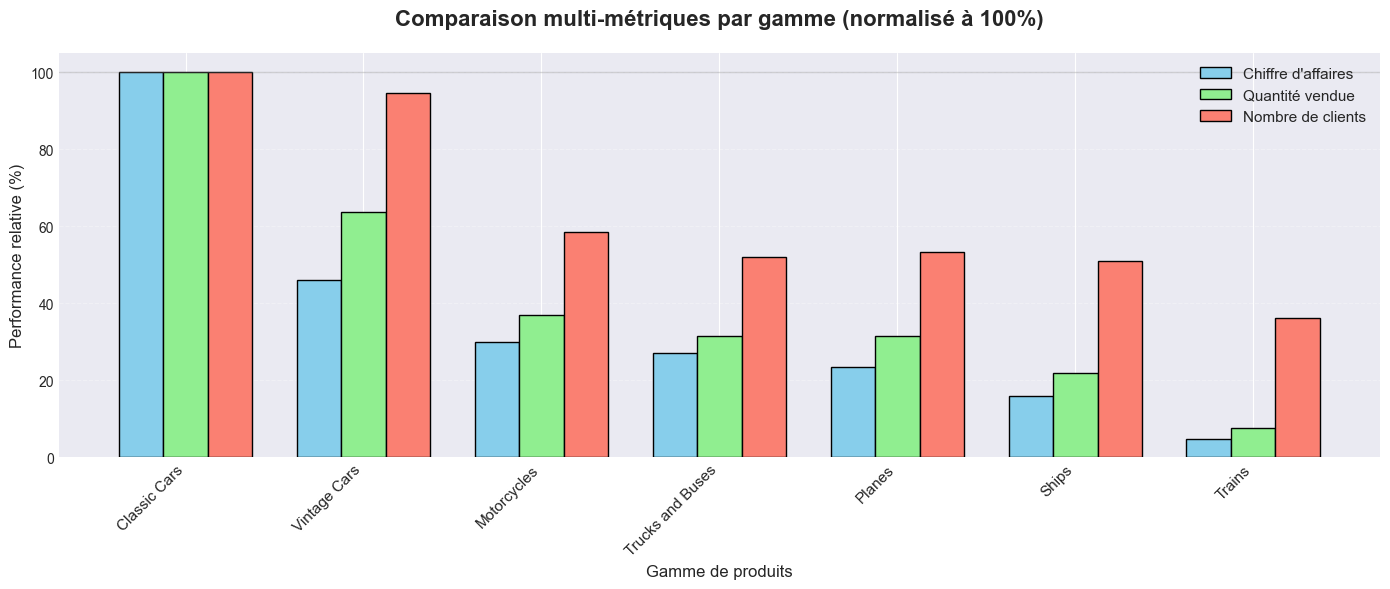


📊 INTERPRÉTATION - PROFILS DE GAMMES :

• Classic Cars :
  - Prix moyen : $108.32
  - CA par client : $39619.20
  → Milieu de gamme - clients à forte valeur

• Vintage Cars :
  - Prix moyen : $78.30
  - CA par client : $19296.48
  → Entrée de gamme - clients à forte valeur

• Motorcycles :
  - Prix moyen : $87.79
  - CA par client : $20245.49
  → Milieu de gamme - clients à forte valeur

• Trucks and Buses :
  - Prix moyen : $93.02
  - CA par client : $20559.72
  → Milieu de gamme - clients à forte valeur

• Planes :
  - Prix moyen : $80.23
  - CA par client : $17396.22
  → Milieu de gamme - clients à forte valeur

• Ships :
  - Prix moyen : $77.76
  - CA par client : $12258.33
  → Entrée de gamme - clients à forte valeur

• Trains :
  - Prix moyen : $66.02
  - CA par client : $5147.96
  → Entrée de gamme - clients à forte valeur


In [19]:
# Cellule 18 : Graphique 12 - Comparaison multi-métriques normalisées

if df_gamme is not None and len(df_gamme) > 0:
    fig4, ax4 = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(df_gamme))
    width = 0.25
    
    # Normalisation (éviter division par zéro)
    ca_max = df_gamme['chiffre_affaires'].max()
    qte_max = df_gamme['quantite_vendue'].max()
    clients_max = df_gamme['nombre_clients'].max()
    
    ca_norm = (df_gamme['chiffre_affaires'] / ca_max * 100) if ca_max > 0 else 0
    qte_norm = (df_gamme['quantite_vendue'] / qte_max * 100) if qte_max > 0 else 0
    clients_norm = (df_gamme['nombre_clients'] / clients_max * 100) if clients_max > 0 else 0
    
    # Création des barres groupées
    bars1 = ax4.bar(x - width, ca_norm, width, label='Chiffre d\'affaires', 
                   color='skyblue', edgecolor='black', linewidth=1)
    bars2 = ax4.bar(x, qte_norm, width, label='Quantité vendue', 
                   color='lightgreen', edgecolor='black', linewidth=1)
    bars3 = ax4.bar(x + width, clients_norm, width, label='Nombre de clients', 
                   color='salmon', edgecolor='black', linewidth=1)
    
    # Personnalisation
    ax4.set_xlabel('Gamme de produits', fontsize=12)
    ax4.set_ylabel('Performance relative (%)', fontsize=12)
    ax4.set_title('Comparaison multi-métriques par gamme (normalisé à 100%)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax4.set_xticks(x)
    ax4.set_xticklabels(df_gamme['gamme'], rotation=45, ha='right', fontsize=11)
    ax4.legend(fontsize=11, loc='upper right')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax4.axhline(y=100, color='gray', linestyle='-', alpha=0.3, linewidth=1)
    
    viz.safe_plot(fig4, 'comparaison_multimetriques_gamme.png')
    
    # Interprétation
    print("\n📊 INTERPRÉTATION - PROFILS DE GAMMES :")
    
    for i, row in df_gamme.iterrows():
        gamme = row['gamme']
        ca_val = row['chiffre_affaires']
        qte_val = row['quantite_vendue']
        clients_val = row['nombre_clients']
        
        # Calcul des ratios
        prix_moyen = ca_val / qte_val if qte_val > 0 else 0
        ca_par_client = ca_val / clients_val if clients_val > 0 else 0
        
        print(f"\n• {gamme} :")
        print(f"  - Prix moyen : ${prix_moyen:.2f}")
        print(f"  - CA par client : ${ca_par_client:.2f}")
        
        # Détermination du positionnement
        if prix_moyen > 150:
            position = "Haut de gamme"
        elif prix_moyen > 80:
            position = "Milieu de gamme"
        else:
            position = "Entrée de gamme"
        
        if ca_par_client > 200:
            client_type = "clients à forte valeur"
        elif ca_par_client > 100:
            client_type = "clients de valeur moyenne"
        else:
            client_type = "clients grand public"
        
        print(f"  → {position} - {client_type}")

### Graphique 3.5 : Relation prix vs quantité par gamme

Ce nuage de points explore la relation entre le prix moyen et la quantité vendue pour chaque gamme.
- La taille des points est proportionnelle au CA
- La couleur indique le nombre de clients
- La ligne de tendance (rouge) montre la relation globale

Cette analyse permet d'identifier l'élasticité-prix par gamme.

✅ Graphique sauvegardé: visualizations/relation_prix_quantite_gamme.png


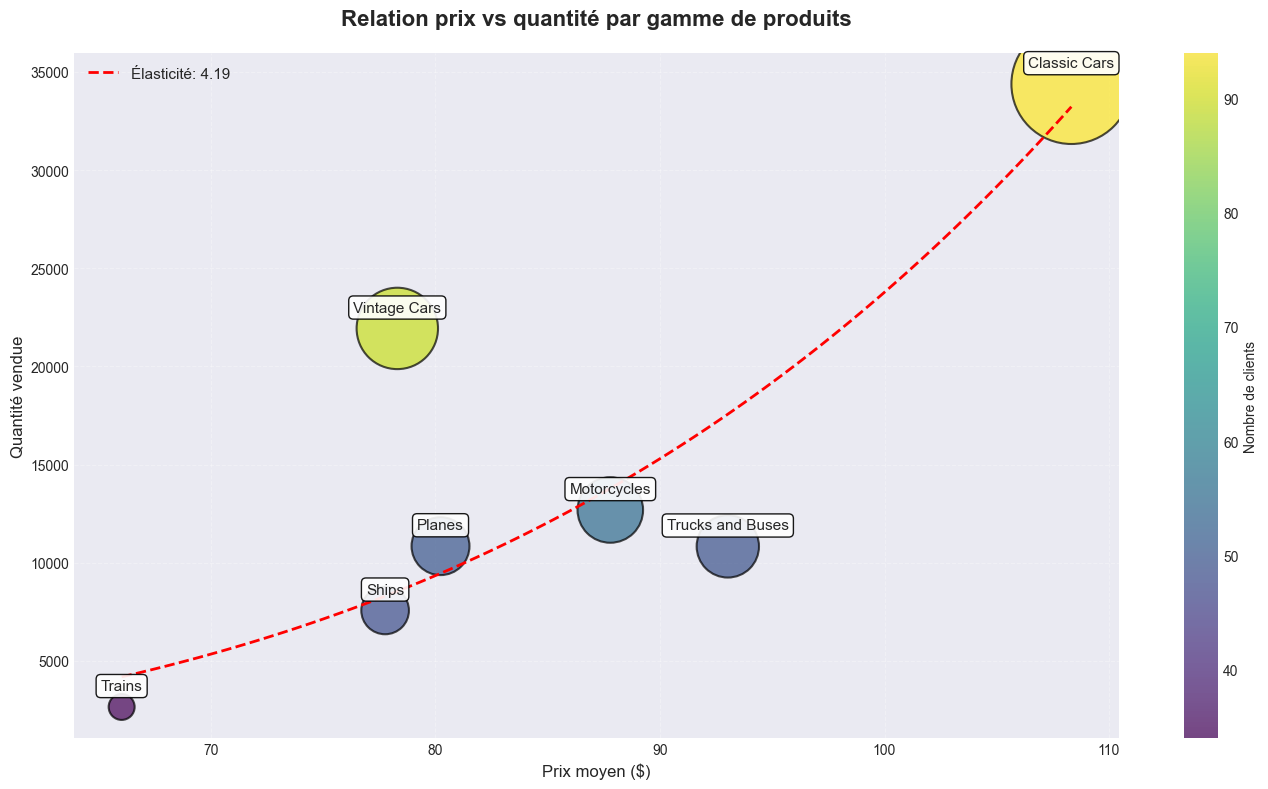


📈 INTERPRÉTATION - ÉLASTICITÉ PRIX :
• Élasticité prix : 4.19
  → Relation positive (effet Veblen/Veblen)
    Plus le prix est élevé, plus la demande est forte

🎯 SEGMENTATION DES GAMMES :

⚖️ MILIEU DE GAMME STRATÉGIQUE : Planes
   → Stratégie : équilibre volume/valeur, cœur de gamme

📊 Données sauvegardées: visualizations/donnees_par_gamme.csv


In [20]:
# Cellule 19 : Graphique 13 - Relation prix vs quantité par gamme

if df_gamme is not None and len(df_gamme) > 0:
    fig5, ax5 = plt.subplots(figsize=(14, 8))
    
    # Calcul du prix moyen réel (CA/quantité)
    df_gamme['prix_moyen_reel'] = df_gamme['chiffre_affaires'] / df_gamme['quantite_vendue']
    
    mask = (df_gamme['prix_moyen_reel'] > 0) & (df_gamme['quantite_vendue'] > 0)
    if mask.any():
        df_plot = df_gamme[mask].copy()
        
        # Création du scatter plot
        scatter = ax5.scatter(df_plot['prix_moyen_reel'], df_plot['quantite_vendue'],
                             s=df_plot['chiffre_affaires']/500,
                             c=df_plot['nombre_clients'], 
                             alpha=0.7, cmap='viridis', 
                             edgecolors='black', linewidth=1.5)
        
        # Ajout des annotations
        for i, row in df_plot.iterrows():
            ax5.annotate(row['gamme'], 
                       (row['prix_moyen_reel'], row['quantite_vendue']),
                       fontsize=11, ha='center', va='bottom',
                       xytext=(0, 10), textcoords='offset points',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
        
        # Personnalisation
        ax5.set_xlabel('Prix moyen ($)', fontsize=12)
        ax5.set_ylabel('Quantité vendue', fontsize=12)
        ax5.set_title('Relation prix vs quantité par gamme de produits', 
                     fontsize=16, fontweight='bold', pad=20)
        ax5.grid(True, alpha=0.3, linestyle='--')
        
        # Barre de couleur
        cbar = plt.colorbar(scatter, ax=ax5, label='Nombre de clients')
        cbar.ax.tick_params(labelsize=10)
        
        # Droite de tendance (log-log pour meilleure visualisation)
        try:
            from scipy import stats
            log_prix = np.log(df_plot['prix_moyen_reel'])
            log_qte = np.log(df_plot['quantite_vendue'])
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_prix, log_qte)
            
            x_trend = np.linspace(df_plot['prix_moyen_reel'].min(), 
                                 df_plot['prix_moyen_reel'].max(), 100)
            y_trend = np.exp(intercept) * x_trend**slope
            ax5.plot(x_trend, y_trend, 'r--', linewidth=2, 
                    label=f'Élasticité: {slope:.2f}')
            ax5.legend(fontsize=11)
        except:
            pass
        
        viz.safe_plot(fig5, 'relation_prix_quantite_gamme.png')
        
        # Interprétation
        print("\n📈 INTERPRÉTATION - ÉLASTICITÉ PRIX :")
        if 'slope' in locals():
            print(f"• Élasticité prix : {slope:.2f}")
            if slope < -1:
                print("  → Forte élasticité (les clients sont très sensibles au prix)")
                print("    Une baisse de prix augmenterait significativement les ventes")
            elif slope < -0.5:
                print("  → Élasticité modérée")
                print("    Le prix est un facteur important mais pas unique")
            elif slope < 0:
                print("  → Faible élasticité (prix peu déterminant)")
                print("    Les clients achètent pour d'autres raisons que le prix")
            else:
                print("  → Relation positive (effet Veblen/Veblen)")
                print("    Plus le prix est élevé, plus la demande est forte")
        
        # Segmentation des gammes
        print("\n🎯 SEGMENTATION DES GAMMES :")
        
        # Haut de gamme (prix élevé, volume faible)
        haut_gamme = df_plot[(df_plot['prix_moyen_reel'] > df_plot['prix_moyen_reel'].quantile(0.66)) & 
                             (df_plot['quantite_vendue'] < df_plot['quantite_vendue'].quantile(0.33))]
        if len(haut_gamme) > 0:
            print(f"\n💎 HAUT DE GAMME : {', '.join(haut_gamme['gamme'].tolist())}")
            print("   → Stratégie : valorisation, exclusivité, marge élevée")
        
        # Entrée de gamme (prix bas, volume élevé)
        entree_gamme = df_plot[(df_plot['prix_moyen_reel'] < df_plot['prix_moyen_reel'].quantile(0.33)) & 
                               (df_plot['quantite_vendue'] > df_plot['quantite_vendue'].quantile(0.66))]
        if len(entree_gamme) > 0:
            print(f"\n📦 ENTRÉE DE GAMME : {', '.join(entree_gamme['gamme'].tolist())}")
            print("   → Stratégie : volume, rotation rapide, prix compétitifs")
        
        # Produits stratégiques (équilibre)
        strategique = df_plot[(df_plot['prix_moyen_reel'] > df_plot['prix_moyen_reel'].quantile(0.33)) & 
                              (df_plot['prix_moyen_reel'] < df_plot['prix_moyen_reel'].quantile(0.66)) &
                              (df_plot['quantite_vendue'] > df_plot['quantite_vendue'].quantile(0.33)) & 
                              (df_plot['quantite_vendue'] < df_plot['quantite_vendue'].quantile(0.66))]
        if len(strategique) > 0:
            print(f"\n⚖️ MILIEU DE GAMME STRATÉGIQUE : {', '.join(strategique['gamme'].tolist())}")
            print("   → Stratégie : équilibre volume/valeur, cœur de gamme")
    
    # Sauvegarde des données
    df_gamme.to_csv(f'{viz.output_dir}/donnees_par_gamme.csv', index=False)
    print(f"\n📊 Données sauvegardées: {viz.output_dir}/donnees_par_gamme.csv")

# PARTIE 4 : ANALYSE DES TOP PRODUITS

## Objectif de l'analyse

L'analyse des top produits permet d'identifier les articles les plus performants du catalogue. Nous allons examiner :

1. **Les produits les plus vendus** (en quantité)
2. **Les produits générant le plus de chiffre d'affaires**
3. **La répartition par gamme des meilleurs produits**
4. **La relation prix vs quantité au niveau produit**

Cette analyse est cruciale pour la gestion des stocks, les stratégies de cross-selling et les décisions d'approvisionnement.

## Requête SQL utilisée

```sql
SELECT 
    p.productCode,
    p.productName,
    p.productLine,
    p.productVendor,
    SUM(od.quantityOrdered) AS quantite_totale,
    SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
    AVG(od.priceEach) AS prix_moyen,
    COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
    COUNT(DISTINCT o.customerNumber) AS nombre_clients
FROM products p
JOIN orderdetails od ON p.productCode = od.productCode
JOIN orders o ON od.orderNumber = o.orderNumber
WHERE o.status NOT IN ('Cancelled', 'On Hold')
GROUP BY p.productCode, p.productName, p.productLine, p.productVendor
ORDER BY quantite_totale DESC
LIMIT 20

In [21]:

# Cellule 20 : Extraction des données top produits

def top_produits(viz):
    """Analyse des top produits"""
    print("🏆 Génération des graphiques des top produits...")
    
    query = """
    SELECT 
        p.productCode,
        p.productName,
        p.productLine,
        p.productVendor,
        SUM(od.quantityOrdered) AS quantite_totale,
        SUM(od.quantityOrdered * od.priceEach) AS chiffre_affaires,
        AVG(od.priceEach) AS prix_moyen,
        COUNT(DISTINCT o.orderNumber) AS nombre_commandes,
        COUNT(DISTINCT o.customerNumber) AS nombre_clients
    FROM products p
    JOIN orderdetails od ON p.productCode = od.productCode
    JOIN orders o ON od.orderNumber = o.orderNumber
    WHERE o.status NOT IN ('Cancelled', 'On Hold')
    GROUP BY p.productCode, p.productName, p.productLine, p.productVendor
    ORDER BY quantite_totale DESC
    LIMIT 20
    """
    
    df = viz.execute_query(query)
    
    if df.empty:
        print("❌ Aucun produit trouvé")
        return None
    
    # Conversion numérique
    df = viz.convert_to_numeric(df,
        ['quantite_totale', 'chiffre_affaires', 'prix_moyen', 
         'nombre_commandes', 'nombre_clients'])
    df = df.fillna(0)
    
    return df

# Exécution
df_top = top_produits(viz)

if df_top is not None:
    df_top10 = df_top.head(10)
    print(f"\n✅ {len(df_top)} produits dans le top 20")
    print("\n📋 Aperçu des données (Top 5) :")
    display(df_top[['productName', 'productLine', 'quantite_totale', 'chiffre_affaires']].head())

🏆 Génération des graphiques des top produits...

✅ 20 produits dans le top 20

📋 Aperçu des données (Top 5) :


,productName,productLine,quantite_totale,chiffre_affaires
0,1992 Ferrari 360 Spider red,Classic Cars,1748.0,268068.18
1,1937 Lincoln Berline,Vintage Cars,1111.0,102563.52
2,1969 Harley Davidson Ultimate Chopper,Motorcycles,1057.0,90157.77
3,1957 Chevy Pickup,Trucks and Buses,1056.0,109946.21
4,1913 Ford Model T Speedster,Vintage Cars,1038.0,97193.88
